In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
import pandas as pd

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from warnings import filterwarnings

import tensorflow as tf
keras = tf.keras

from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout, LSTM
from keras.layers import Conv1D, LSTM, MaxPooling1D, InputLayer
from keras.losses import Huber
from keras import backend as K

import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy.optimize import curve_fit
from fbprophet import Prophet



In [157]:
url = 'https://raw.githubusercontent.com/PrestonBlackburn/production-data-texas/master/Texas_well_production.csv'
Data = pd.read_csv(url)

series = Data['Production'].values
time = Data.index
fb_date = Data['Date'].values

print(time)

RangeIndex(start=0, stop=321, step=1)


In [158]:
split_time = 300

time_train = time[:split_time]
x_train = series[:split_time]
fb_date_train = fb_date[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]
fb_date_valid = fb_date[split_time:]

In [60]:
## Decline Curves:
def Exponential(t, di):
    qi = Data['Production'].max()
    return qi*np.exp(-di*t)
    
def Hyperbolic(t, b, di):
    qi = Data['Production'].max()
    return qi/((1.0+b*di*t)**(1/b))

def Harmonic(t, qi, di):
    return qi/(1+di*t)


# simple graph function
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Production (bbls)")
    if label: 
        plt.legend(fontsize=14)
    plt.grid(True)

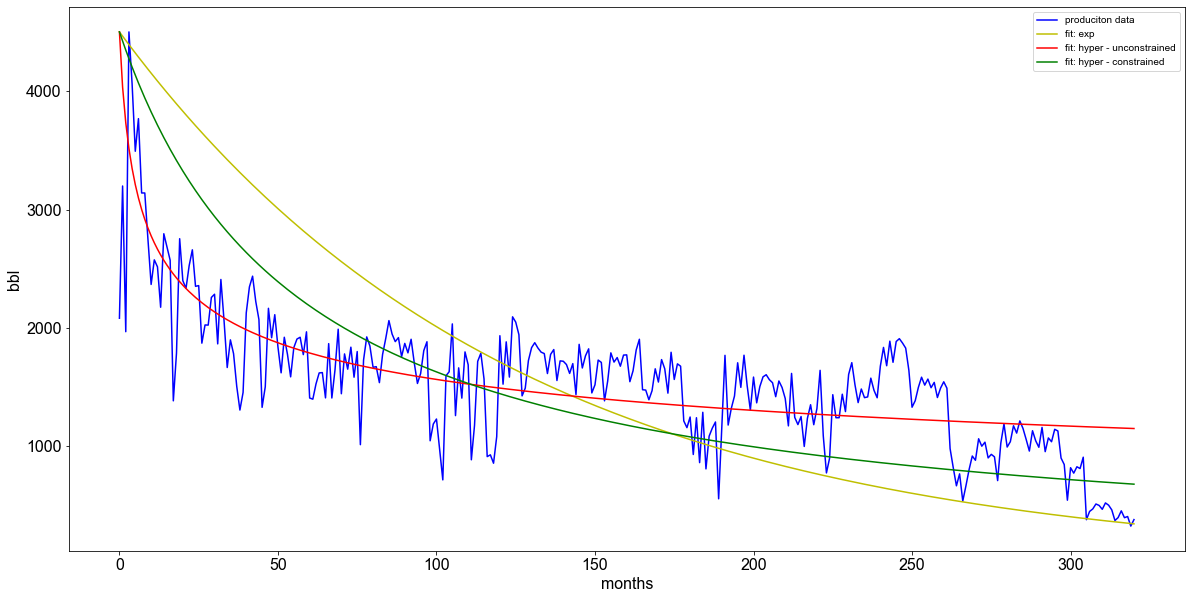

In [61]:
plt.figure(figsize=(20, 10))

qi = Data['Production'].max()


popt, pcov = curve_fit(Exponential, time, series)
exp_vars = popt
popt, pcov = curve_fit(Hyperbolic, time, series)
unconstrained_vars = popt
popt, pcov = curve_fit(Hyperbolic, time, series, bounds= ([0,0], [1,5]))
constrained_vars = popt

plt.plot(time, series,'b-', label = 'produciton data')
plt.plot(time, Exponential(time, *exp_vars), 'y-', label = 'fit: exp' )
plt.plot(time, Hyperbolic(time, *unconstrained_vars), 'r-', label = 'fit: hyper - unconstrained' )
plt.plot(time, Hyperbolic(time, *constrained_vars), 'g-', label = 'fit: hyper - constrained' )
plt.xlabel('months')
plt.ylabel('bbl')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (321,) and (271, 41)

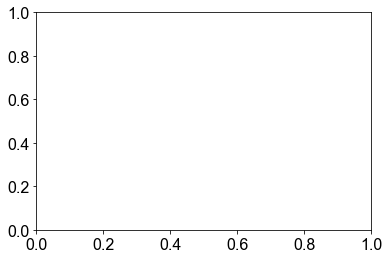

# Exponential Regression
# $ q = \frac{q_i}{(1+bd_it)^{\frac{1}{b}}}$

## $ q_i =$ initial production
## $ t =$ time since begining of production
## $ b = $decline constant
## $ d_i = $initial nominal decline rate

In [62]:
obs_X = time
obs_Y = Data['Production'].values
qi_seed = Data['Production'].max()

In [66]:
with pm.Model() as model:
    qi = pm.Normal('qi', mu=qi_seed, sd = 1000)
    di = pm.Normal('di',mu=0, sd = 100)
    b_const = pm.Normal('b_const',mu=0, sd = 100)
    sigma = pm.Uniform('sigma', 0 , 1000)
    

In [67]:
with model:
    # Regression
    mean = qi/((1.0+b_const*di*obs_X)**(1/b_const))
    #mean = pm.Deterministic("mean", qi/((1.0+b*di*obs_X)**(1/b_const)))
    obs = pm.Normal("obs", mu=mean, sd=sigma, observed=obs_Y)
    
    #trace = pm.sample(10000, step=pm.Metropolis())
    trace = pm.sample(75000, cores=1, step=pm.Metropolis())
    burned_trace = trace[20000:]

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [sigma]
INFO:pymc3:>Metropolis: [sigma]
>Metropolis: [b_const]
INFO:pymc3:>Metropolis: [b_const]
>Metropolis: [di]
INFO:pymc3:>Metropolis: [di]
>Metropolis: [qi]
INFO:pymc3:>Metropolis: [qi]


Sampling 2 chains for 1_000 tune and 75_000 draw iterations (2_000 + 150_000 draws total) took 72 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 75_000 draw iterations (2_000 + 150_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\Preston\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Preston\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000171347FFD90>,
      dtype=object)

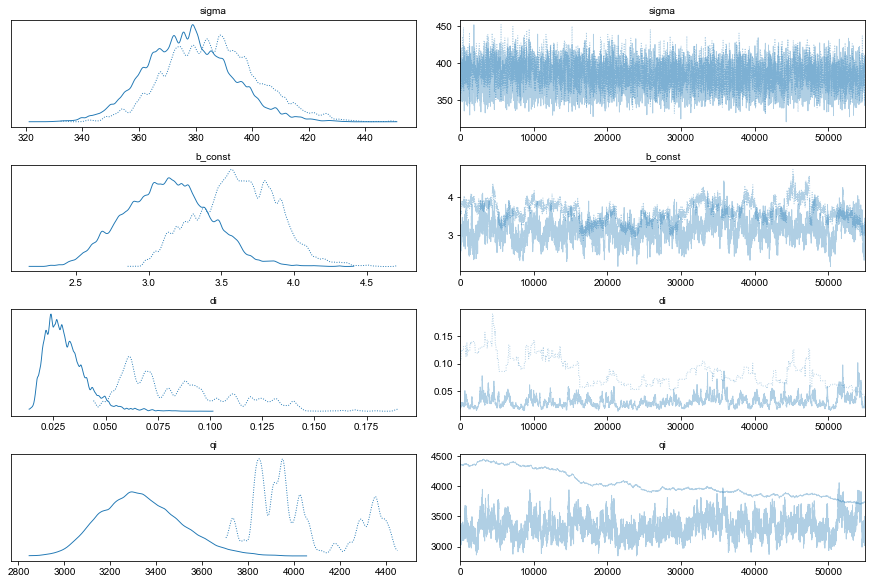

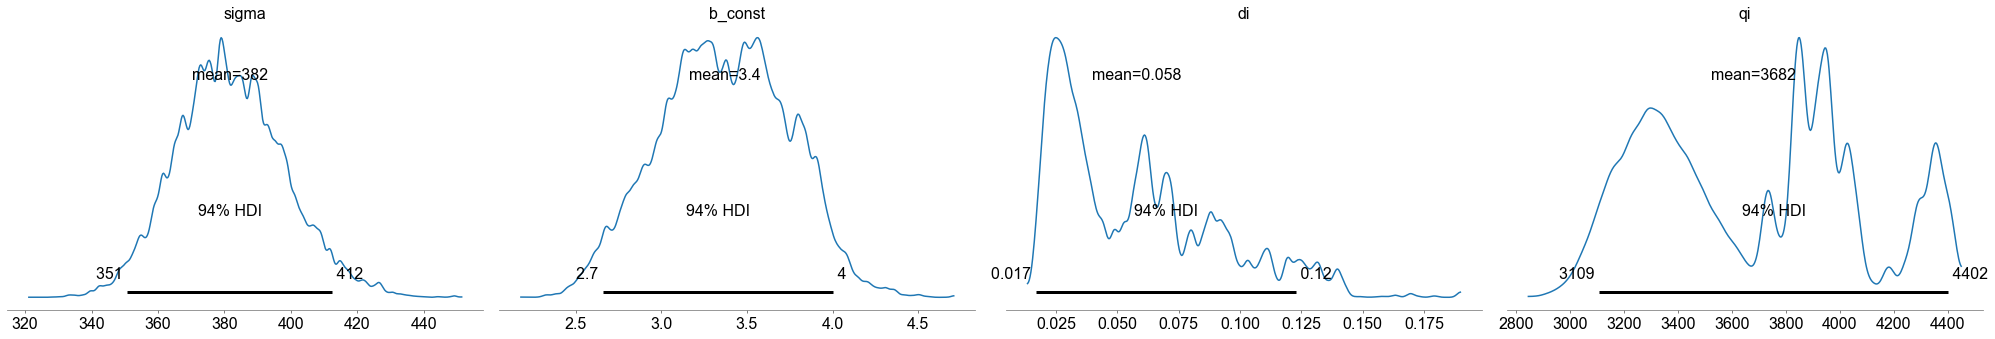

In [68]:
pm.plots.traceplot(burned_trace, var_names=["sigma", "b_const", "di", "qi"])
pm.plot_posterior(burned_trace, var_names=["sigma", "b_const", "di","qi"])

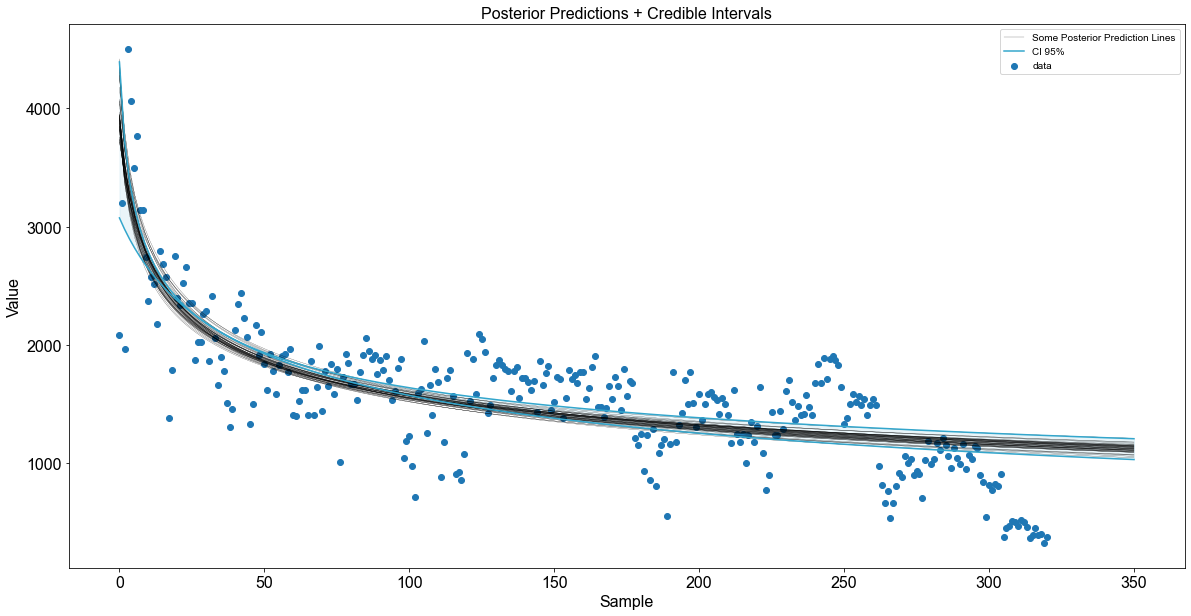

In [69]:
## Making Predictions 5 months ahead
pred_range = np.linspace(0, 350, 200)

qi = Data['Production'].max()

b_95= np.quantile(burned_trace['b_const'], .975)
di_95 = np.quantile(burned_trace['di'], .975)
qi_95 = np.quantile(burned_trace['qi'], .975)
b_5 = np.quantile(burned_trace['b_const'], .025)
di_5 =np.quantile(burned_trace['di'], .025)
qi_5 = np.quantile(burned_trace['qi'], .025)

b_mu = np.mean(burned_trace['b_const'])
di_mu =np.mean(burned_trace['di'])
qi_mu = np.mean(burned_trace['qi'])



def calc_regression_line(x, b, di):
    return qi/((1.0+b*di*x)**(1/b))


plt.figure(figsize=(20, 10))
lm = lambda x, sample: (sample['qi'] / ((1 + sample['b_const'] *sample['di'] * x)**(1/sample['b_const'])))
lm_cred = lambda x, sample: (sample['qi'] / ((1 + sample['b_const'] *sample['di'] * x)**(1/sample['b_const']))) + sample['sigma']

plt.scatter(obs_X, obs_Y, label='data')
pm.plot_posterior_predictive_glm(burned_trace, samples=50, eval=pred_range,
                                 label='Some Posterior Prediction Lines',
                                lm = lm)

plt.fill_between(pred_range, (qi_95 / ((1 + b_95 * di_95 * pred_range)**(1/b_95))),
                 (qi_5 / ((1 + b_5 * di_5 * pred_range)**(1/b_5))), alpha=0.1, color="#33a6cc")
#plt.fill_between(pred_range, calc_regression_line(pred_range, beta_75, alpha_75),
#                 calc_regression_line(pred_range, beta_25, alpha_25), alpha=0.1, color="#3359cc")

plt.plot(pred_range, (qi_95 / ((1 + b_95 * di_95 * pred_range)**(1/b_95))), color="#33a6cc", label = "CI 95%")
plt.plot(pred_range, (qi_5 / ((1 + b_5 * di_5 * pred_range)**(1/b_5))), color="#33a6cc")
#plt.plot(pred_range, calc_regression_line(pred_range, beta_75, alpha_75), color="#3359cc", label = "CI 50%")
#plt.plot(pred_range, calc_regression_line(pred_range, beta_25, alpha_25), color="#3359cc")


plt.title('Posterior Predictions + Credible Intervals')
plt.legend(loc=0)
plt.xlabel('Sample')
plt.ylabel('Value');

# FB Prophet - Bayesian Inference

In [159]:
print(len(fb_date))
print(len(series))

321
321


In [163]:
df = pd.DataFrame()
df['ds'] = fb_date
confidence = 0.95
df['y'] = series
df2 = df[['ds','y']][:-40]
df2.tail


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


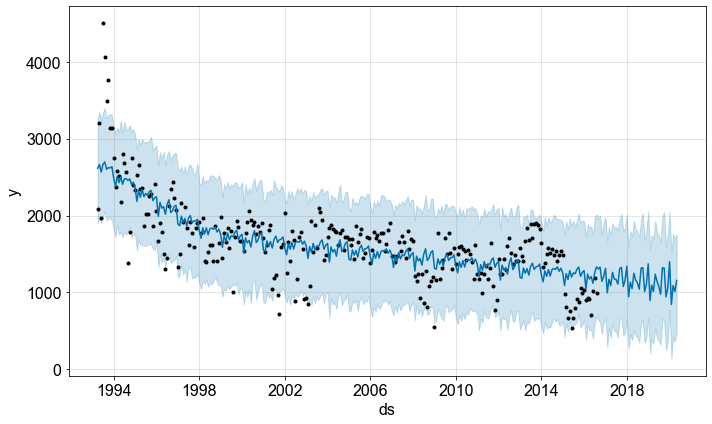

In [168]:

m = Prophet(interval_width = confidence, changepoint_prior_scale = 0.05)
m.fit(df2)
future = m.make_future_dataframe(periods=45, freq = 'M')
#future['cap'] = 1.0
forecast = m.predict(future)
fig = m.plot(forecast)


In [129]:
future_df = forecast
fb_values = forecast['yhat'].values
fb_upper = forecast['yhat_upper'].values
fb_lower = forecast['yhat_lower'].values

# Bayesian Neural Network (by MC Dropout)

In [73]:
df2 = pd.DataFrame({
    'time': time,
    'values': Data['Production'].values
})
print(len(df2))

321


In [74]:

test_train_split = 321

train, test = df2[:test_train_split], df2[test_train_split:]

In [75]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [76]:
#period used to forecast
window = 40


#target/timestep
lag, lag_size = 10, 10

series = series_to_supervised(train.drop('time', axis=1), window=window, lag=lag)
series.tail()


,values(t-40),values(t-39),values(t-38),values(t-37),values(t-36),values(t-35),values(t-34),values(t-33),values(t-32),values(t-31),...,values(t-8),values(t-7),values(t-6),values(t-5),values(t-4),values(t-3),values(t-2),values(t-1),values(t),values(t+10)
306,533.0,662.0,800.0,914.0,878.0,1060.0,997.0,1031.0,898.0,928.0,...,842.0,540.0,815.0,769.0,823.0,808.0,904.0,375.0,445.0,450.0
307,662.0,800.0,914.0,878.0,1060.0,997.0,1031.0,898.0,928.0,907.0,...,540.0,815.0,769.0,823.0,808.0,904.0,375.0,445.0,466.0,392.0
308,800.0,914.0,878.0,1060.0,997.0,1031.0,898.0,928.0,907.0,706.0,...,815.0,769.0,823.0,808.0,904.0,375.0,445.0,466.0,508.0,402.0
309,914.0,878.0,1060.0,997.0,1031.0,898.0,928.0,907.0,706.0,1023.0,...,769.0,823.0,808.0,904.0,375.0,445.0,466.0,508.0,496.0,321.0
310,878.0,1060.0,997.0,1031.0,898.0,928.0,907.0,706.0,1023.0,1186.0,...,823.0,808.0,904.0,375.0,445.0,466.0,508.0,496.0,463.0,376.0


In [77]:
# Label
labels_col = 'values(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, shuffle=False)
X_valid, X_test = X_valid.iloc[0:-window], X_valid.iloc[-window:]
Y_valid, Y_test = Y_valid[0:-window], Y_valid[-window:]

print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
print('test set shape', X_test.shape)

Train set shape (162, 41)
Validation set shape (69, 41)
test set shape (40, 41)


In [78]:
## prep shape for CNN
n_features = 1

X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], n_features))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (162, 41, 1)
Validation set shape (69, 41, 1)
Test set shape (40, 41, 1)


In [79]:
#inp_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])
inp_shape=(X_train_series.shape[1], X_train_series.shape[2])
dropout_rate = 0.5
def gen_model():
    inp = Input(shape=inp_shape)
    x = Conv1D(input_shape=inp_shape, filters=32, kernel_size=3, strides=1, dilation_rate=1, padding="causal", activation="relu")(inp)
    #x = Dropout(rate=dropout_rate)(x, training=True)
    for dilation_rate in (2, 4, 8, 16, 32):
    #for dilation_rate in (2, 4, 8):
        x = Conv1D(filters=32, kernel_size=3, strides=1, dilation_rate=dilation_rate, padding="causal", activation="relu")(x)
        #x = Dropout(rate=dropout_rate)(x, training=True)
    x = LSTM(16, activation='relu')(x)
    x = Dropout(rate=dropout_rate)(x, training=True)
    x = Dense(32, activation='relu')(x)
    x = Dropout(rate=dropout_rate)(x, training=True)
    outputs = Dense(1)(x)
    #outputs = Conv1D(filters=1, kernel_size=1)(x)
    
    
    model = keras.Model(inputs=inp, outputs=outputs)
    optimizer = keras.optimizers.Adam(lr=1e-3)
    model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model

In [80]:
wave_mc_model = gen_model()
model_checkpoint = keras.callbacks.ModelCheckpoint(r'C:/Data Science/Models/Time_Comp_Models/Wave-Net-MC-Dropout-prod.h5')
early_stopping = keras.callbacks.EarlyStopping(patience = 100, restore_best_weights = True)

wave_mc_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 41, 1)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 32)            128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 41, 32)            3104      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 41, 32)            3104      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 41, 32)            3104      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 41, 32)            3104      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 41, 32)           

In [81]:
epoch=500
history = wave_mc_model.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epoch, 
                            verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
6/6 [==============================] - 1s 116ms/step - loss: 1310.6219 - mae: 1311.1219 - val_loss: 1057.3805 - val_mae: 1057.8805
Epoch 2/500
6/6 [==============================] - 0s 21ms/step - loss: 1513.8708 - mae: 1514.3708 - val_loss: 3834.7866 - val_mae: 3835.2866
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 3294.5671 - mae: 3295.0671 - val_loss: 2865.3584 - val_mae: 2865.8577
Epoch 4/500
6/6 [==============================] - 0s 21ms/step - loss: 3529.7507 - mae: 3530.2507 - val_loss: 1653.8118 - val_mae: 1654.3118
Epoch 5/500
6/6 [==============================] - 0s 21ms/step - loss: 1779.9396 - mae: 1780.4396 - val_loss: 1817.4524 - val_mae: 1817.9524
Epoch 6/500
6/6 [==============================] - 0s 21ms/step - loss: 2333.0247 - mae: 2333.5247 - val_loss: 1685.3896 - val_mae: 1685.8896
Epoch 7/500
6/6 [==============================] - 0s 19ms/step - loss: 1739.5648 - mae: 1740.0648 - val_loss: 1167.8071 - val_mae: 1168.3071
Epoch

Epoch 118/500
6/6 [==============================] - 0s 16ms/step - loss: 693.8412 - mae: 694.3412 - val_loss: 507.5429 - val_mae: 508.0385
Epoch 119/500
6/6 [==============================] - 0s 16ms/step - loss: 697.3210 - mae: 697.8188 - val_loss: 507.1073 - val_mae: 507.6073
Epoch 120/500
6/6 [==============================] - 0s 21ms/step - loss: 671.4760 - mae: 671.9760 - val_loss: 547.8496 - val_mae: 548.3496
Epoch 121/500
6/6 [==============================] - 0s 16ms/step - loss: 724.8839 - mae: 725.3839 - val_loss: 604.4751 - val_mae: 604.9751
Epoch 122/500
6/6 [==============================] - 0s 17ms/step - loss: 697.9303 - mae: 698.4303 - val_loss: 579.2253 - val_mae: 579.7253
Epoch 123/500
6/6 [==============================] - 0s 17ms/step - loss: 649.6837 - mae: 650.1837 - val_loss: 582.9774 - val_mae: 583.4774
Epoch 124/500
6/6 [==============================] - 0s 16ms/step - loss: 642.8059 - mae: 643.3059 - val_loss: 547.4651 - val_mae: 547.9651
Epoch 125/500
6/6 [=

6/6 [==============================] - 0s 17ms/step - loss: 544.8424 - mae: 545.3424 - val_loss: 492.0841 - val_mae: 492.5841
Epoch 235/500
6/6 [==============================] - 0s 17ms/step - loss: 601.7956 - mae: 602.2956 - val_loss: 531.9404 - val_mae: 532.4404
Epoch 236/500
6/6 [==============================] - 0s 17ms/step - loss: 522.5811 - mae: 523.0811 - val_loss: 586.5729 - val_mae: 587.0729
Epoch 237/500
6/6 [==============================] - 0s 18ms/step - loss: 563.3373 - mae: 563.8373 - val_loss: 480.6041 - val_mae: 481.1041
Epoch 238/500
6/6 [==============================] - 0s 17ms/step - loss: 601.2720 - mae: 601.7720 - val_loss: 596.8214 - val_mae: 597.3214
Epoch 239/500
6/6 [==============================] - 0s 17ms/step - loss: 562.4409 - mae: 562.9409 - val_loss: 527.2383 - val_mae: 527.7383
Epoch 240/500
6/6 [==============================] - 0s 16ms/step - loss: 556.4180 - mae: 556.9180 - val_loss: 487.7784 - val_mae: 488.2784
Epoch 241/500
6/6 [===============

6/6 [==============================] - 0s 17ms/step - loss: 535.4080 - mae: 535.9080 - val_loss: 541.1325 - val_mae: 541.6325
Epoch 351/500
6/6 [==============================] - 0s 17ms/step - loss: 615.3886 - mae: 615.8886 - val_loss: 522.7936 - val_mae: 523.2936
Epoch 352/500
6/6 [==============================] - 0s 16ms/step - loss: 571.7113 - mae: 572.2113 - val_loss: 521.5035 - val_mae: 522.0035
Epoch 353/500
6/6 [==============================] - 0s 17ms/step - loss: 616.5886 - mae: 617.0886 - val_loss: 494.7449 - val_mae: 495.2449
Epoch 354/500
6/6 [==============================] - 0s 18ms/step - loss: 562.3411 - mae: 562.8394 - val_loss: 477.1458 - val_mae: 477.6458
Epoch 355/500
6/6 [==============================] - 0s 18ms/step - loss: 592.6862 - mae: 593.1862 - val_loss: 538.3489 - val_mae: 538.8489
Epoch 356/500
6/6 [==============================] - 0s 17ms/step - loss: 525.8829 - mae: 526.3829 - val_loss: 475.4197 - val_mae: 475.9197
Epoch 357/500
6/6 [===============

In [82]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
380,573.535583,574.035583,572.545471,573.045471,380
381,539.929565,540.427673,437.377625,437.877625,381
382,568.230530,568.730530,512.862366,513.362366,382
383,580.161987,580.661987,536.484070,536.984070,383
384,544.655884,545.155884,518.265686,518.765686,384


In [83]:
wave_forecast = wave_mc_model.predict(X_valid_series)

In [84]:
#print(np.shape(wave_forecast))
#print(wave_forecast)

In [85]:
print(Y_valid)

[1613. 1241. 1180. 1248.  995. 1233. 1348. 1179. 1316. 1639. 1085.  771.
  896. 1433. 1238. 1238. 1437. 1290. 1604. 1704. 1517. 1366. 1481. 1408.
 1414. 1573. 1470. 1407. 1674. 1833. 1678. 1886. 1707. 1883. 1907. 1870.
 1827. 1639. 1327. 1382. 1495. 1581. 1514. 1565. 1492. 1537. 1409. 1489.
 1542. 1488.  977.  815.  662.  763.  533.  662.  800.  914.  878. 1060.
  997. 1031.  898.  928.  907.  706. 1023. 1186.  990.]


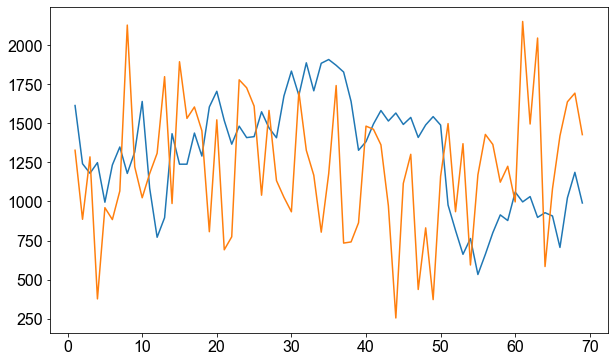

In [86]:
plt.figure(figsize=(10, 6))
time_len = np.linspace(1, len(Y_valid), len(Y_valid))
plt.plot(time_len, Y_valid)
plt.plot(time_len, wave_forecast)
#plot_series(time_valid, wave_forecast)

In [87]:
mc_pred = []
for i in tqdm.tqdm(range(500)):
    y_p = wave_mc_model.predict(X_valid_series)
    mc_pred.append(y_p)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 26.24it/s]


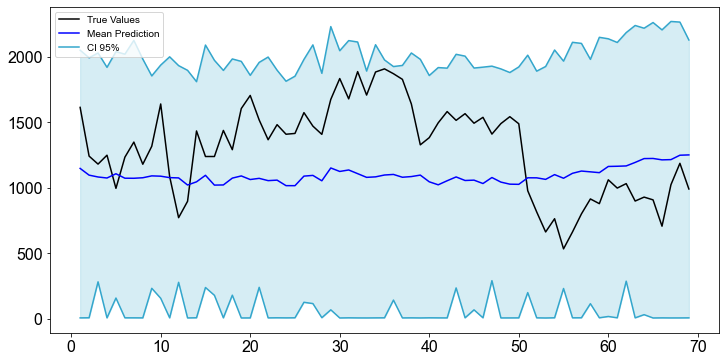

In [88]:
upper_pred = np.quantile(mc_pred, .975, axis=0)
lower_pred = np.quantile(mc_pred, .025, axis=0)
mean_pred = np.mean(mc_pred, axis=0)


plt.figure(figsize=(12, 6))
plt.plot(time_len, Y_valid, color="black", label = "True Values")
plt.plot(time_len, mean_pred, color="blue", label = "Mean Prediction")
plt.fill_between(time_len.flatten(), upper_pred.flatten(), lower_pred.flatten(), color="#33a6cc", alpha=.2)
plt.plot(time_len, upper_pred, color="#33a6cc", label = "CI 95%")
plt.plot(time_len, lower_pred, color="#33a6cc")
plt.legend()

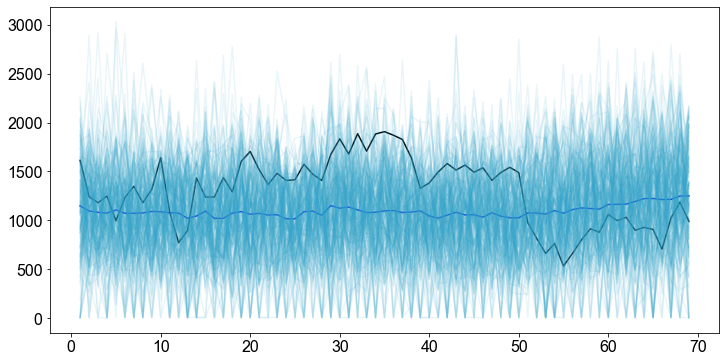

In [89]:
plt.figure(figsize=(12, 6))

plt.plot(time_len, Y_valid, color="black", label = "True Values")
plt.plot(time_len, mean_pred, color="blue", label = "Mean Prediction")

for i in range(0,200):
    plt.plot(time_len, mc_pred[:][i], color="#33a6cc", alpha=.1)
    

### Test Set

In [90]:
test_forecast = wave_mc_model.predict(X_test_series)

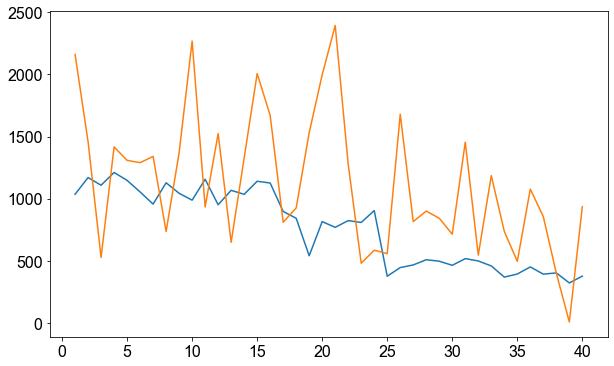

In [91]:
plt.figure(figsize=(10, 6))
time_len = np.linspace(1, len(Y_test), len(Y_test))
plt.plot(time_len, Y_test)
plt.plot(time_len, test_forecast)
#plot_series(time_valid, wave_forecast)

In [92]:
mc_pred = []
for i in tqdm.tqdm(range(500)):
    y_p = wave_mc_model.predict(X_test_series)
    mc_pred.append(y_p)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.50it/s]


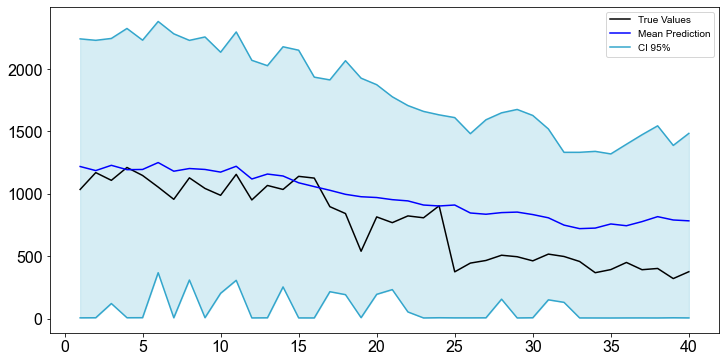

In [93]:
upper_pred_test = np.quantile(mc_pred, .975, axis=0)
lower_pred_test = np.quantile(mc_pred, .025, axis=0)
mean_pred_test = np.mean(mc_pred, axis=0)


plt.figure(figsize=(12, 6))
plt.plot(time_len, Y_test, color="black", label = "True Values")
plt.plot(time_len, mean_pred_test, color="blue", label = "Mean Prediction")
plt.fill_between(time_len.flatten(), upper_pred_test.flatten(), lower_pred_test.flatten(), color="#33a6cc", alpha=.2)
plt.plot(time_len, upper_pred_test, color="#33a6cc", label = "CI 95%")
plt.plot(time_len, lower_pred_test, color="#33a6cc")
plt.legend()

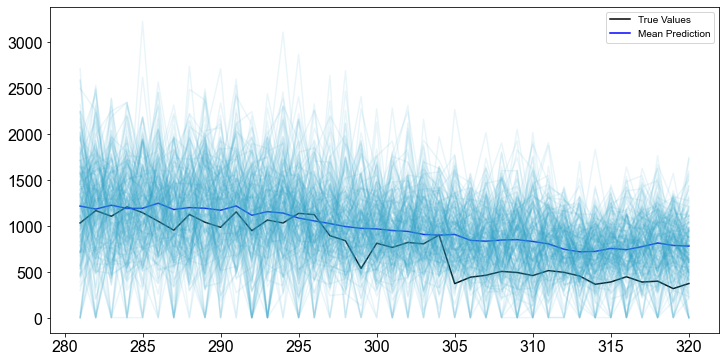

In [96]:
plt.figure(figsize=(12, 6))

plt.plot(X_time[-window:], Y_test, color="black", label = "True Values")
plt.plot(X_time[-window:], mean_pred_test, color="blue", label = "Mean Prediction")

for i in range(0,200):
    plt.plot(X_time[-window:], mc_pred[:][i], color="#33a6cc", alpha=.1)
plt.legend() 

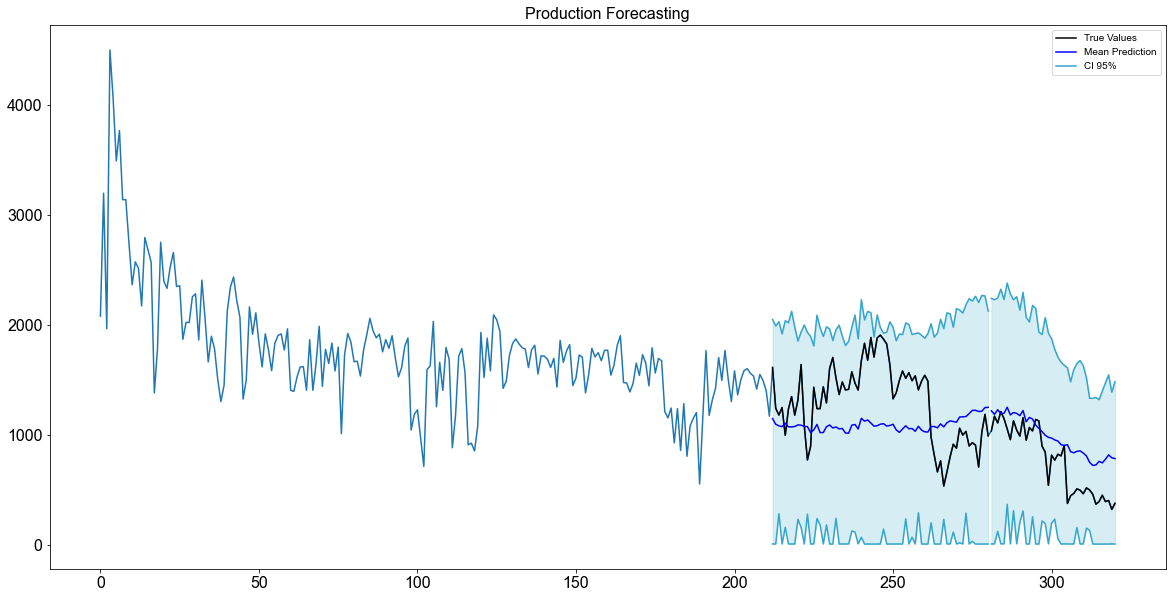

In [95]:
plt.figure(figsize=(20, 10))


X_time = time
Y_data = Data['Production'].values
plt.plot(X_time, Y_data)
plt.title("Production Forecasting")


plt.plot(X_time[-(len(Y_valid)+window):-window], Y_valid, color="black")
plt.plot(X_time[-(len(Y_valid)+window):-window], mean_pred, color="blue")
plt.fill_between(X_time[-(len(Y_valid)+window):-window], upper_pred.flatten(), lower_pred.flatten(), color="#33a6cc", alpha=.2)
plt.plot(X_time[-(len(Y_valid)+window):-window], upper_pred, color="#33a6cc")
plt.plot(X_time[-(len(Y_valid)+window):-window], lower_pred, color="#33a6cc")

plt.plot(X_time[-window:], Y_test, color="black", label = "True Values")
plt.plot(X_time[-window:], mean_pred_test, color="blue", label = "Mean Prediction")
plt.fill_between(X_time[-window:], upper_pred_test.flatten(), lower_pred_test.flatten(), color="#33a6cc", alpha=.2)
plt.plot(X_time[-window:], upper_pred_test, color="#33a6cc", label = "CI 95%")
plt.plot(X_time[-window:], lower_pred_test, color="#33a6cc")
plt.legend()

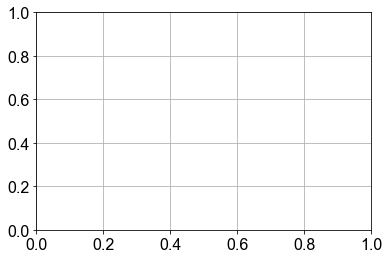

In [56]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.grid(True)


In [ ]:
fig.savefig(r'C:\Users\Preston\Bayesian Stats Practice\figures\plot.png', dpi=(600), bbox_inches='tight')

# Comparison of Methods

In [53]:
def stats_comp(true_vals, pred, label):
    mse = mean_squared_error(true_vals, pred)
    RMSE = mse**(1/2)
    mae = mean_absolute_error(true_vals, pred)
    print(f"{label}, RMSE: {RMSE}")
    print(f"{label}, MAE: {mae}")
    return RMSE, mae
    

Text(0.5, 1.0, 'Bayesian Methods Comparison')

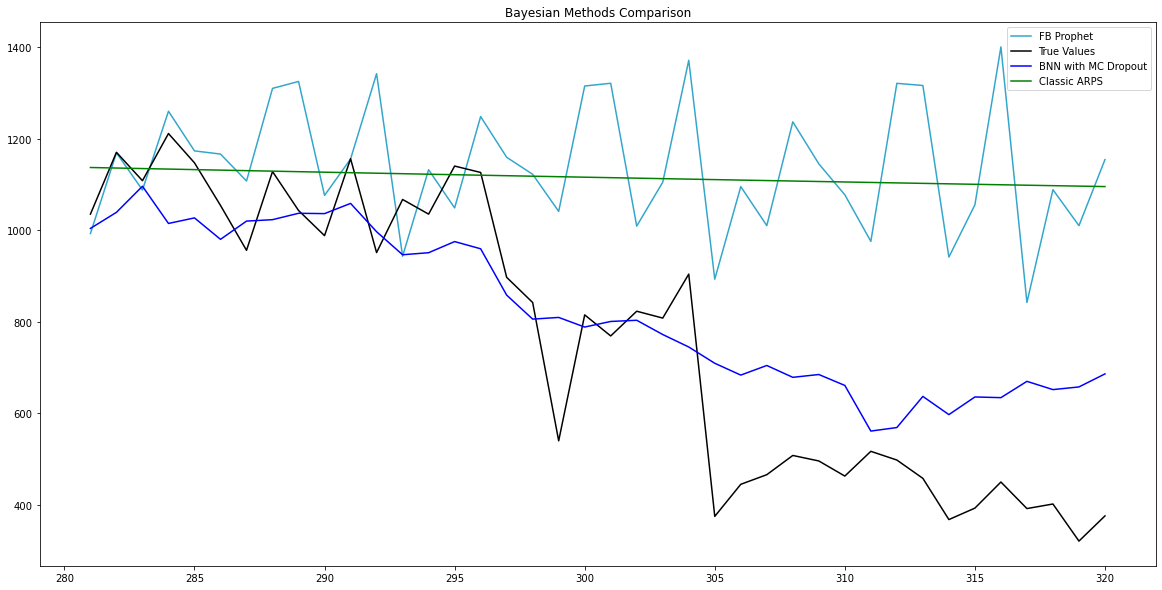

In [54]:
plt.figure(figsize=(20, 10))

plt.plot(time[-window:], fb_values[-window:], label = "FB Prophet",  color="#33a6cc")
plt.plot(time[-window:], Y_test, label = "True Values", color = "black")
plt.plot(time[-window:], mean_pred_test, label = "BNN with MC Dropout", color="blue")

arps_pred = time[-window:]
arps_bays = (qi_mu / ((1 + b_mu * di_mu * arps_pred)**(1/b_mu)))
plt.plot(time[-window:], arps_bays, label = "Classic ARPS", color='green')
         
plt.legend()
plt.title("Bayesian Methods Comparison")



In [55]:
stats_comp(time[-window:], arps_bays, "ARPS")
stats_comp(time[-window:], fb_values[-window:], "FB Prophet")
stats_comp(time[-window:],  mean_pred_test, "Dialated CNN with MC Dropout")


ARPS, RMSE: 815.3077822054129
ARPS, MAE: 814.958458363976
FB Prophet, RMSE: 849.5713224297028
FB Prophet, MAE: 837.9233582115739
Dialated CNN with MC Dropout, RMSE: 552.6364320456672
Dialated CNN with MC Dropout, MAE: 523.6525665283203


(552.6364320456672, 523.6525665283203)

# Plots for post

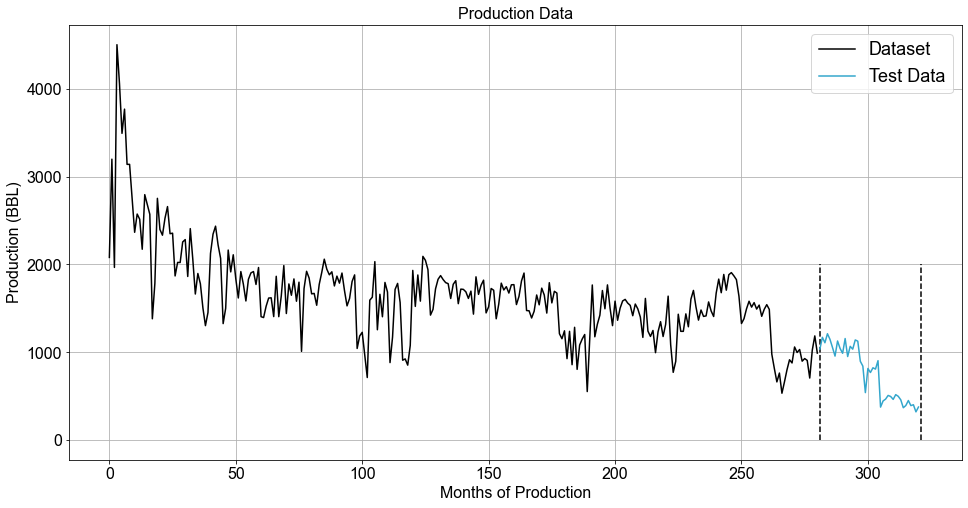

In [143]:
plt.figure(figsize=(16, 8))
plt.grid(True)


plt.plot(X_time[:-window], Data['Production'].values[:-window], color="black", label = "Dataset")
plt.plot(X_time[-window:], Data['Production'].values[-window:], color="#33a6cc", label = "Test Data")
plt.vlines((len(X_time)-window), 0, 2000, linestyles='--')
plt.vlines((len(X_time)), 0, 2000, linestyles='--')

plt.legend(prop={'size': 18})
plt.title("Production Data")
plt.xlabel("Months of Production")
plt.ylabel("Production (BBL)")
plt.savefig(r'C:\Users\Preston\Bayesian Stats Practice\figures\well_data.png', dpi=(600), bbox_inches='tight')

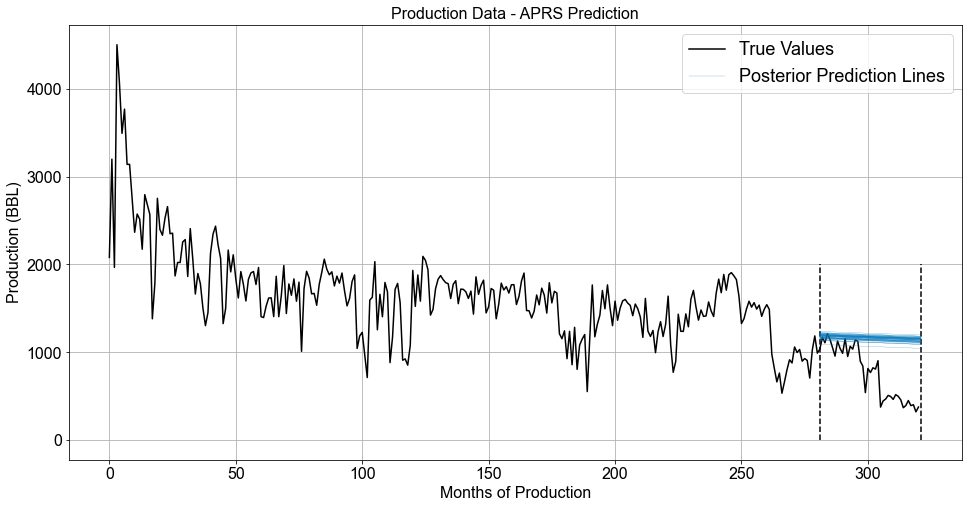

In [190]:
plt.figure(figsize=(16, 8))
plt.grid(True)

pred_range = np.linspace(281, 321, 200)

plt.plot(X_time, Data['Production'].values, color="black", label = "True Values")
pm.plot_posterior_predictive_glm(burned_trace, samples= 50, eval=pred_range,
                                 label='Posterior Prediction Lines',
                                lm = lm, color='#0277BD')

plt.vlines((len(X_time)-window), 0, 2000, linestyles='--')
plt.vlines((len(X_time)), 0, 2000, linestyles='--')
plt.legend(prop={'size': 18})
plt.title("Production Data - APRS Prediction")
plt.xlabel("Months of Production")
plt.ylabel("Production (BBL)")

plt.savefig(r'C:\Users\Preston\Bayesian Stats Practice\figures\ARPS_data.png', dpi=(600), bbox_inches='tight')
#plt.fill_between(pred_range, (qi_95 / ((1 + b_95 * di_95 * pred_range)**(1/b_95))),
#                 (qi_5 / ((1 + b_5 * di_5 * pred_range)**(1/b_5))), alpha=0.1, color="#33a6cc")
#plt.fill_between(pred_range, calc_regression_line(pred_range, beta_75, alpha_75),
#                 calc_regression_line(pred_range, beta_25, alpha_25), alpha=0.1, color="#3359cc")

#plt.plot(pred_range, (qi_95 / ((1 + b_95 * di_95 * pred_range)**(1/b_95))), color="#33a6cc", label = "CI 95%")
#plt.plot(pred_range, (qi_5 / ((1 + b_5 * di_5 * pred_range)**(1/b_5))), color="#33a6cc")
#plt.plot(pred_range, calc_regression_line(pred_range, beta_75, alpha_75), color="#3359cc", label = "CI 50%")
#plt.plot(pred_range, calc_regression_line(pred_range, beta_25, alpha_25), color="#3359cc")

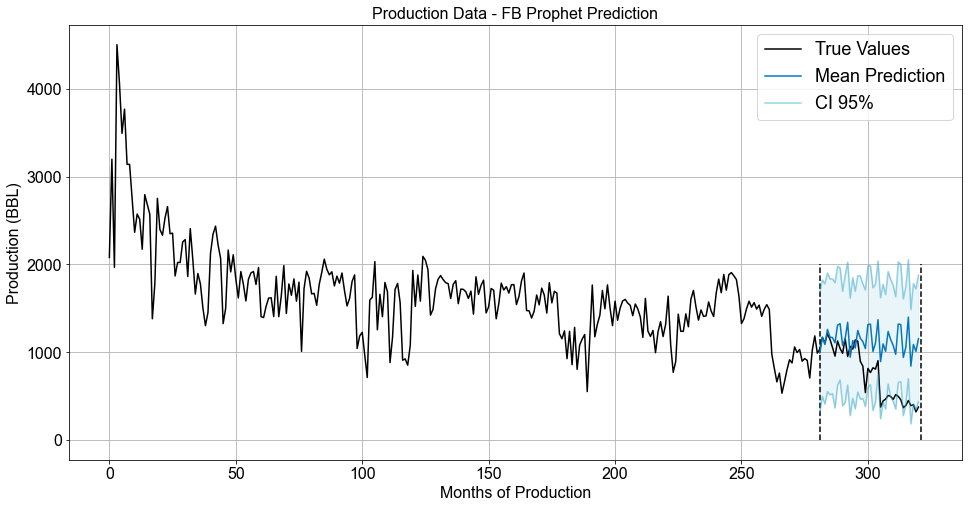

In [189]:
plt.figure(figsize=(16, 8))
plt.grid(True)

plt.plot(X_time, Data['Production'].values, color="black", label = "True Values")
plt.plot(time[-window:], fb_values[-window:], label = "Mean Prediction",  color='#0277BD')

plt.fill_between(time[-window:], fb_upper[-window:].flatten(), fb_lower[-window:].flatten(), color="#33a6cc", alpha=.1)
plt.plot(time[-window:], fb_upper[-window:], color="#33a6cc", label = "CI 95%", alpha = 0.5)
plt.plot(time[-window:], fb_lower[-window:], color="#33a6cc", alpha= 0.5)

plt.vlines((len(X_time)-window), 0, 2000, linestyles='--')
plt.vlines((len(X_time)), 0, 2000, linestyles='--')

plt.legend(prop={'size': 18})
plt.title("Production Data - FB Prophet Prediction")
plt.xlabel("Months of Production")
plt.ylabel("Production (BBL)")


plt.savefig(r'C:\Users\Preston\Bayesian Stats Practice\figures\fb_data.png', dpi=(600), bbox_inches='tight')

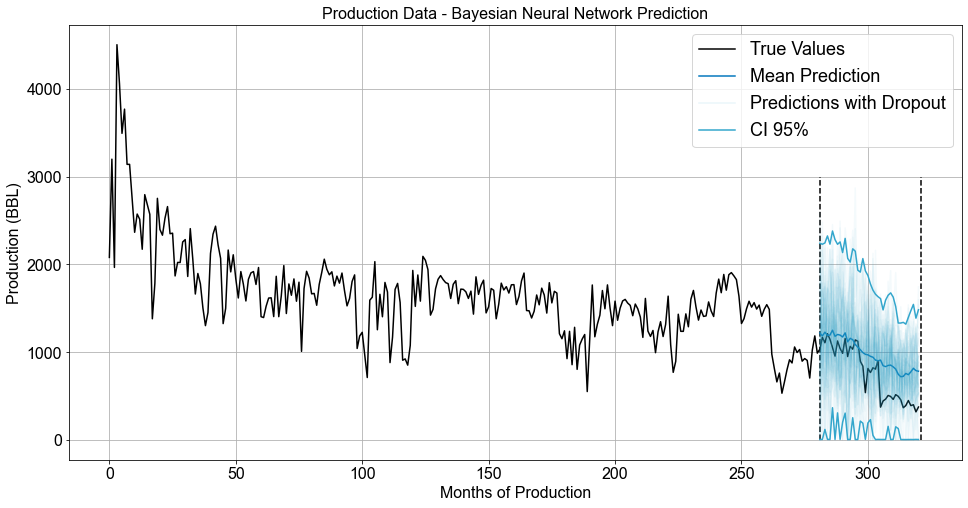

In [193]:
plt.figure(figsize=(16, 8))
plt.grid(True)


plt.plot(X_time, Data['Production'].values, color="black", label = "True Values")

plt.plot(X_time[-window:], mean_pred_test, color='#0277BD', label = "Mean Prediction")
plt.vlines((len(X_time)-window), 0, 3000, linestyles='--')
plt.vlines((len(X_time)), 0, 3000, linestyles='--')

for i in range(0,50):
    plt.plot(X_time[-window:], mc_pred[:][i], color="#33a6cc", alpha=.05)

plt.plot(X_time[-window:], mc_pred[:][i], color="#33a6cc", alpha=.1, label="Predictions with Dropout")

plt.plot(X_time[-window:], upper_pred_test, color="#33a6cc", label = "CI 95%")
plt.plot(X_time[-window:], lower_pred_test, color="#33a6cc")


plt.legend(prop={'size': 18})
plt.title("Production Data - Bayesian Neural Network Prediction")
plt.xlabel("Months of Production")
plt.ylabel("Production (BBL)")

plt.savefig(r'C:\Users\Preston\Bayesian Stats Practice\figures\MC_dropout_data.png', dpi=(600), bbox_inches='tight')

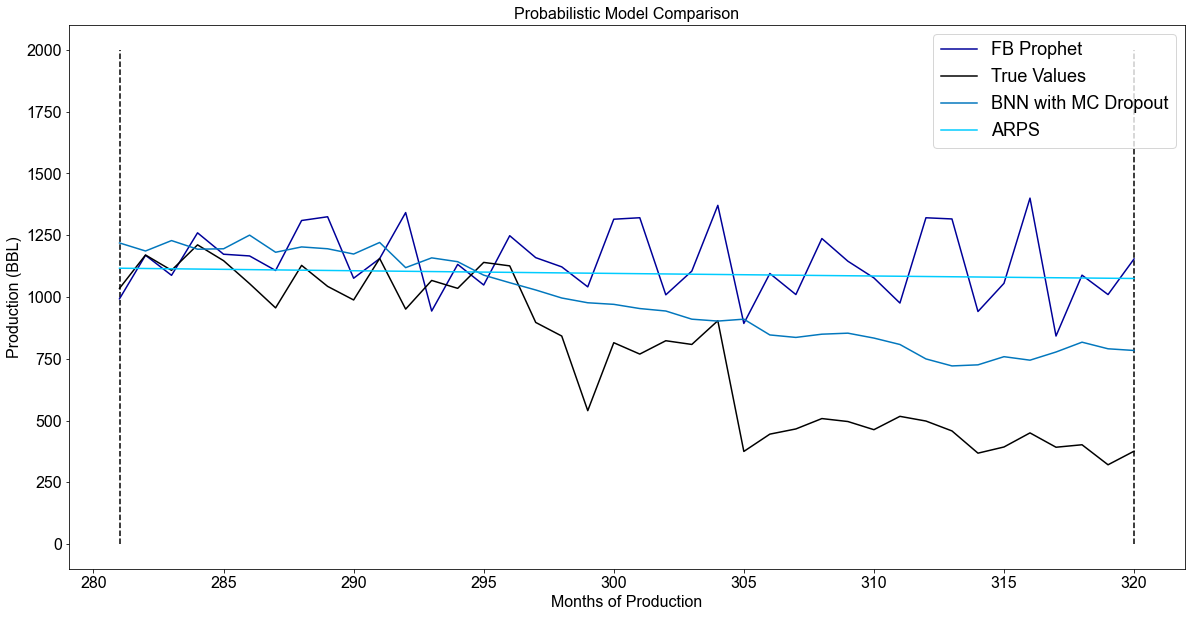

In [220]:
plt.figure(figsize=(20, 10))

plt.plot(time[-window:], fb_values[-window:], label = "FB Prophet",  color="#000099")
plt.plot(time[-window:], Y_test, label = "True Values", color = "black")
#plt.plot(X_time, Data['Production'].values, color="black", label = "True Values")
plt.plot(time[-window:], mean_pred_test, label = "BNN with MC Dropout", color='#0277BD')

arps_pred = time[-window:]
arps_bays = (qi_mu / ((1 + b_mu * di_mu * arps_pred)**(1/b_mu)))
plt.plot(time[-window:], arps_bays, label = "ARPS", color='#00CCFF')

plt.vlines((len(X_time)-window), 0, 2000, linestyles='--')
plt.vlines((len(X_time)-1), 0, 2000, linestyles='--')    

plt.legend(prop={'size': 18})
plt.title("Probabilistic Model Comparison")
plt.xlabel("Months of Production")
plt.ylabel("Production (BBL)")


plt.savefig(r'C:\Users\Preston\Bayesian Stats Practice\figures\Model_comparisons.png', dpi=(600), bbox_inches='tight')

In [212]:
def stats_comp(true_vals, pred, label):
    mse = mean_squared_error(true_vals, pred)
    RMSE = mse**(1/2)
    mae = mean_absolute_error(true_vals, pred)
    print(f"{label}, RMSE: {RMSE}")
    print(f"{label}, MAE: {mae}")
    return round(RMSE, 2), round(mae,2)
    

In [214]:
arps_rmse, arps_mae = stats_comp(time[-window:], arps_bays, "ARPS")
fb_rmse, fb_mae = stats_comp(time[-window:], fb_values[-window:], "FB Prophet")
CNN_rmse, CNN_mae = stats_comp(time[-window:],  mean_pred_test, "Dialated CNN with MC Dropout")

tot_rmse = [arps_rmse, fb_rmse, CNN_rmse]
tot_mae = [arps_mae, fb_mae, CNN_mae]
all_models = ['ARPS', 'FB Prophet', 'Bayesian Neural Network']

ARPS, RMSE: 795.0450608367742
ARPS, MAE: 794.687641369757
FB Prophet, RMSE: 849.5713224297028
FB Prophet, MAE: 837.9233582115739
Dialated CNN with MC Dropout, RMSE: 706.9549934030093
Dialated CNN with MC Dropout, MAE: 681.9456573486328


In [216]:
stats_df = pd.DataFrame({
    'Model': all_models,
    'RMSE': tot_rmse,
    'MAE': tot_mae
    
})

#stats_df = stats_df.set_index('Model')
stats_df.head()

,Model,RMSE,MAE
0,ARPS,795.05,794.69
1,FB Prophet,849.57,837.92
2,Bayesian Neural Network,706.95,681.95
